In [2]:
# Overfitting and Regularization
# http://gluon.mxnet.io/chapter02_supervised-learning/regularization-scratch.html#Overfitting-and-regularization

from __future__ import print_function
import mxnet as mx
import mxnet.ndarray as nd
from mxnet import autograd
import numpy as np
ctx = mx.cpu()
mx.random.seed(1)


# for plotting purposes
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt


In [3]:

mnist = mx.test_utils.get_mnist()
num_examples = 1000
batch_size = 64
train_data = mx.gluon.data.DataLoader(
    mx.gluon.data.ArrayDataset(mnist["train_data"][:num_examples],
                               mnist["train_label"][:num_examples].astype(np.float32)),
                               batch_size, shuffle=True)
test_data = mx.gluon.data.DataLoader(
    mx.gluon.data.ArrayDataset(mnist["test_data"][:num_examples],
                               mnist["test_label"][:num_examples].astype(np.float32)),
                               batch_size, shuffle=False)

In [4]:
# Allocate model parameters and define model
W = nd.random_normal(shape=(784,10))
b = nd.random_normal(shape=10)

params = [W, b]

for param in params:
    param.attach_grad()

def net(X):
    y_linear = nd.dot(X, W) + b
    yhat = nd.softmax(y_linear, axis=1)
    return yhat

In [5]:
# Loss and Optimizer function
def cross_entropy(yhat, y):
    return - nd.sum(y * nd.log(yhat), axis=0, exclude=True)

def SGD(params, lr):
    for param in params:
        param[:] = param - lr * param.grad

In [6]:
# evaluation loop to calc accuracy
def evaluate_accuracy(data_iterator, net):
    numerator = 0.
    denominator = 0.
    loss_avg = 0.
    for i, (data, label) in enumerate(data_iterator):
        data = data.as_in_context(ctx).reshape((-1,784))
        label = label.as_in_context(ctx)
        label_one_hot = nd.one_hot(label, 10)
        output = net(data)
        loss = cross_entropy(output, label_one_hot)
        predictions = nd.argmax(output, axis=1)
        numerator += nd.sum(predictions == label)
        denominator += data.shape[0]
        loss_avg = loss_avg*i/(i+1) + nd.mean(loss).asscalar()/(i+1)
    return (numerator / denominator).asscalar(), loss_avg

In [7]:
# plot learning curves
def plot_learningcurves(loss_tr,loss_ts, acc_tr,acc_ts):
    xs = list(range(len(loss_tr)))

    f = plt.figure(figsize=(12,6))
    fg1 = f.add_subplot(121)
    fg2 = f.add_subplot(122)

    fg1.set_xlabel('epoch',fontsize=14)
    fg1.set_title('Comparing loss functions')
    fg1.semilogy(xs, loss_tr)
    fg1.semilogy(xs, loss_ts)
    fg1.grid(True,which="both")

    fg1.legend(['training loss', 'testing loss'],fontsize=14)

    fg2.set_title('Comparing accuracy')
    fg1.set_xlabel('epoch',fontsize=14)
    fg2.plot(xs, acc_tr)
    fg2.plot(xs, acc_ts)
    fg2.grid(True,which="both")
    fg2.legend(['training accuracy', 'testing accuracy'],fontsize=14)

Completed epoch 100. Train Loss: 0.595374753699, Test Loss 1.76260456443, Train_acc 0.876, Test_acc 0.695
Completed epoch 200. Train Loss: 0.26655814983, Test Loss 1.49519494921, Train_acc 0.932, Test_acc 0.73
Completed epoch 300. Train Loss: 0.15451334184, Test Loss 1.43565172702, Train_acc 0.966, Test_acc 0.74
Completed epoch 400. Train Loss: 0.0971810123883, Test Loss 1.41950972006, Train_acc 0.985, Test_acc 0.735
Completed epoch 500. Train Loss: 0.064882760169, Test Loss 1.41649082303, Train_acc 0.992, Test_acc 0.739
Completed epoch 600. Train Loss: 0.0464652667288, Test Loss 1.41421365365, Train_acc 0.997, Test_acc 0.742
Completed epoch 700. Train Loss: 0.0358780863462, Test Loss 1.40811365843, Train_acc 1.0, Test_acc 0.745
Completed epoch 800. Train Loss: 0.029025087133, Test Loss 1.40179941803, Train_acc 1.0, Test_acc 0.747
Completed epoch 900. Train Loss: 0.024541953986, Test Loss 1.39684844762, Train_acc 1.0, Test_acc 0.75
Completed epoch 1000. Train Loss: 0.0213954253122, Tes

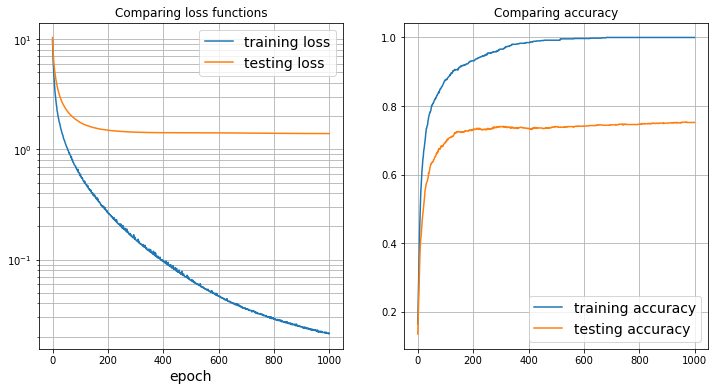

In [8]:
# Run training

epochs = 1000
moving_loss = 0.
niter=0

loss_seq_train = []
loss_seq_test = []
acc_seq_train = []
acc_seq_test = []


for e in range(epochs):
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(ctx).reshape((-1,784))
        label = label.as_in_context(ctx)
        label_one_hot = nd.one_hot(label, 10)
        with autograd.record():
            output = net(data)
            loss = cross_entropy(output, label_one_hot)
        loss.backward()
        SGD(params, .001)

        ##########################
        #  Keep a moving average of the losses
        ##########################
        niter +=1
        moving_loss = .99 * moving_loss + .01 * nd.mean(loss).asscalar()
        est_loss = moving_loss/(1-0.99**niter)

    test_accuracy, test_loss = evaluate_accuracy(test_data, net)
    train_accuracy, train_loss = evaluate_accuracy(train_data, net)

    # save them for later
    loss_seq_train.append(train_loss)
    loss_seq_test.append(test_loss)
    acc_seq_train.append(train_accuracy)
    acc_seq_test.append(test_accuracy)


    if e % 100 == 99:
        print("Completed epoch %s. Train Loss: %s, Test Loss %s, Train_acc %s, Test_acc %s" %
              (e+1, train_loss, test_loss, train_accuracy, test_accuracy))


## Plotting the learning curves
plot_learningcurves(loss_seq_train,loss_seq_test,acc_seq_train,acc_seq_test)


In [9]:
# normalization technique to reduce overfitting
def l2_penalty(params):
    penalty = nd.zeros(shape=1)
    for param in params:
        penalty = penalty + nd.sum(param ** 2)
    return penalty

for param in params:
    param[:] = nd.random_normal(shape=param.shape)

Completed epoch 100. Train Loss: 0.400765549857, Test Loss 1.23921265826, Train_acc 0.886, Test_acc 0.696
Completed epoch 200. Train Loss: 0.196654832922, Test Loss 0.851411037147, Train_acc 0.953, Test_acc 0.76
Completed epoch 300. Train Loss: 0.146932492498, Test Loss 0.679255941883, Train_acc 0.975, Test_acc 0.796
Completed epoch 400. Train Loss: 0.133599861525, Test Loss 0.592815013602, Train_acc 0.989, Test_acc 0.823
Completed epoch 500. Train Loss: 0.1294963127, Test Loss 0.547899600118, Train_acc 0.989, Test_acc 0.832
Completed epoch 600. Train Loss: 0.128637162969, Test Loss 0.526308616623, Train_acc 0.991, Test_acc 0.834
Completed epoch 700. Train Loss: 0.127936861478, Test Loss 0.514143202454, Train_acc 0.992, Test_acc 0.837
Completed epoch 800. Train Loss: 0.129957255907, Test Loss 0.50877392292, Train_acc 0.991, Test_acc 0.837
Completed epoch 900. Train Loss: 0.128591369838, Test Loss 0.504678685218, Train_acc 0.993, Test_acc 0.838
Completed epoch 1000. Train Loss: 0.129612

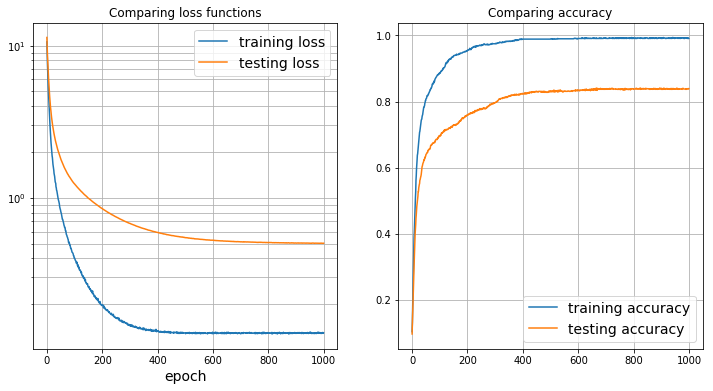

In [10]:

epochs = 1000
moving_loss = 0.
l2_strength = .1
niter=0

loss_seq_train = []
loss_seq_test = []
acc_seq_train = []
acc_seq_test = []


for e in range(epochs):
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(ctx).reshape((-1,784))
        label = label.as_in_context(ctx)
        label_one_hot = nd.one_hot(label, 10)
        with autograd.record():
            output = net(data)
            loss = nd.sum(cross_entropy(output, label_one_hot)) + l2_strength * l2_penalty(params)
        loss.backward()
        SGD(params, .001)

        ##########################
        #  Keep a moving average of the losses
        ##########################
        niter +=1
        moving_loss = .99 * moving_loss + .01 * nd.mean(loss).asscalar()
        est_loss = moving_loss/(1-0.99**niter)


    test_accuracy, test_loss = evaluate_accuracy(test_data, net)
    train_accuracy, train_loss = evaluate_accuracy(train_data, net)

    # save them for later
    loss_seq_train.append(train_loss)
    loss_seq_test.append(test_loss)
    acc_seq_train.append(train_accuracy)
    acc_seq_test.append(test_accuracy)

    if e % 100 == 99:
        print("Completed epoch %s. Train Loss: %s, Test Loss %s, Train_acc %s, Test_acc %s" %
              (e+1, train_loss, test_loss, train_accuracy, test_accuracy))
        
plot_learningcurves(loss_seq_train,loss_seq_test,acc_seq_train,acc_seq_test)